In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys

if IN_COLAB:
    # Code to download the necessary files (e.g. solutions, test funcs)
    if not os.path.exists("chapter1_transformers"):
        !curl -o /content/main.zip https://codeload.github.com/callummcdougall/ARENA_2.0/zip/refs/heads/main
        !unzip /content/main.zip 'ARENA_2.0-main/chapter1_transformers/exercises/*'
        sys.path.append("/content/ARENA_2.0-main/chapter1_transformers/exercises")
        os.remove("/content/main.zip")
        os.rename("ARENA_2.0-main/chapter1_transformers", "chapter1_transformers")
        os.rmdir("ARENA_2.0-main")

         # Install packages
        %pip install einops
        %pip install jaxtyping
        %pip install transformer_lens
        %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
        %pip install s3fs
        %pip install omegaconf
        %pip install git+https://github.com/CindyXWu/devinterp-automata.git
        %pip install torch-ema

        !curl -o /content/main.zip https://codeload.github.com/CindyXWu/devinterp-automata/zip/refs/heads/main
        !unzip -o /content/main.zip -d /content/

        sys.path.append("/content/devinterp-automata/")
        os.remove("/content/main.zip")

        os.chdir("chapter1_transformers/exercises")
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

    CHAPTER = r"chapter1_transformers"
    CHAPTER_DIR = r"./" if CHAPTER in os.listdir() else os.getcwd().split(CHAPTER)[0]
    EXERCISES_DIR = CHAPTER_DIR + f"{CHAPTER}/exercises"
    sys.path.append(EXERCISES_DIR)

In [2]:
from dotenv import load_dotenv
import plotly.express as px
from typing import List, Union, Optional, Dict, Tuple
from jaxtyping import Int, Float

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
import numpy as np
import pandas as pd
import einops
import re
import functools
from tqdm import tqdm
from IPython.display import display
import webbrowser
import gdown
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from transformer_lens.utils import to_numpy

import circuitsvis as cv
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For Dashiell's groups code
from copy import deepcopy
from functools import reduce
from itertools import product
import math
import numpy as np
from operator import mul
import torch

torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAIN = __name__ == "__main__"

import wandb
from pathlib import Path
import os
import yaml
import s3fs
from omegaconf import OmegaConf

from di_automata.config_setup import *
from di_automata.constructors import (
    construct_model,
    create_dataloader_hf,
)
from di_automata.tasks.data_utils import take_n
import plotly.io as pio

# AWS
load_dotenv()
AWS_KEY, AWS_SECRET = os.getenv("AWS_KEY"), os.getenv("AWS_SECRET")
s3 = s3fs.S3FileSystem(key=AWS_KEY, secret=AWS_SECRET)

/Users/cindy/anaconda3/envs/devinterp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cindy/anaconda3/envs/devinterp/lib/python3.12/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_type" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/cindy/anaconda3/envs/devinterp/lib/python3.12/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_save_method" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [ ]:
from di_automata.interp_utils import (
    imshow_attention,
    line,
    scatter,
    imshow,
    reorder_list_in_plotly_way,
    get_pca,
    get_vars,
)

from di_automata.tasks.dashiell_groups import (
    DihedralElement,
    DihedralIrrep, 
    ProductDihedralIrrep,
    dihedral_conjugacy_classes, 
    generate_subgroup,
    actions_to_labels,
    get_all_bits,
    dihedral_fourier,
    get_fourier_spectrum,
    analyse_power,
)

In [4]:
group = DihedralElement.full_group(5)

In [5]:
translation = {
    (0,0):0,
    (1,0):1,
    (2,0):2,
    (3,0):3,
    (4,0):4,
    (0,1):5,
    (1,1):6,
    (2,1):7,
    (3,1):8,
    (4,1):9,
}

In [6]:
def imshow_attention(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)


In [7]:
update_layout_set = {"xaxis_range", "yaxis_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor", "showlegend", "xaxis_tickmode", "yaxis_tickmode", "margin", "xaxis_visible", "yaxis_visible", "bargap", "bargroupgap", "coloraxis_showscale", "xaxis_tickangle"}
import torch as t

def imshow(tensor: t.Tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    facet_labels = kwargs_pre.pop("facet_labels", None)
    border = kwargs_pre.pop("border", False)
    return_fig = kwargs_pre.pop("return_fig", False)
    text = kwargs_pre.pop("text", None)
    xaxis_tickangle = kwargs_post.pop("xaxis_tickangle", None)
    static = kwargs_pre.pop("static", False)
    if "color_continuous_scale" not in kwargs_pre:
        kwargs_pre["color_continuous_scale"] = "RdBu"
    if "color_continuous_midpoint" not in kwargs_pre:
        kwargs_pre["color_continuous_midpoint"] = 0.0
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    fig = px.imshow(to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post)
    if facet_labels:
        # Weird thing where facet col wrap means labels are in wrong order
        if "facet_col_wrap" in kwargs_pre:
            facet_labels = reorder_list_in_plotly_way(facet_labels, kwargs_pre["facet_col_wrap"])
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label
    if border:
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    if text:
        if tensor.ndim == 2:
            # if 2D, then we assume text is a list of lists of strings
            assert isinstance(text[0], list)
            assert isinstance(text[0][0], str)
            text = [text]
        else:
            # if 3D, then text is either repeated for each facet, or different
            assert isinstance(text[0], list)
            if isinstance(text[0][0], str):
                text = [text for _ in range(len(fig.data))]
        for i, _text in enumerate(text):
            fig.data[i].update(
                text=_text,
                texttemplate="%{text}",
                textfont={"size": 12}
            )
    # Very hacky way of fixing the fact that updating layout with new tickangle only applies to first facet by default
    if xaxis_tickangle is not None:
        n_facets = 1 if tensor.ndim == 2 else tensor.shape[0]
        for i in range(1, 1+n_facets):
            xaxis_name = "xaxis" if i == 1 else f"xaxis{i}"
            fig.layout[xaxis_name]["tickangle"] = xaxis_tickangle
    return fig if return_fig else fig.show(renderer=renderer, config={"staticPlot": static})

def reorder_list_in_plotly_way(L: list, col_wrap: int):
    '''
    Helper function, because Plotly orders figures in an annoying way when there's column wrap.
    '''
    L_new = []
    while len(L) > 0:
        L_new.extend(L[-col_wrap:])
        L = L[:-col_wrap]
    print(f"Reordered labels: {L_new}")
    return L_new

In [8]:
DI_ROOT = Path("/content/devinterp-automata-main/") if IN_COLAB else Path("../")
config_file_path = DI_ROOT / f"scripts/configs/slt_config.yaml"
slt_config = OmegaConf.load(config_file_path)

with open(DI_ROOT / f"scripts/configs/task_config/{slt_config.dataset_type}.yaml", 'r') as file:
    task_config = yaml.safe_load(file)

In [9]:
OmegaConf.set_struct(slt_config, False) # Allow new configuration values to be added
# Because we are in Colab and not VSCode, here is where you want to edit your config values
slt_config["task_config"] = task_config
slt_config["lr"] = 0.0005
slt_config["num_training_iter"] = 30000
slt_config["n_layers"] = 2

# Convert OmegaConf object to MainConfig Pydantic model for dynamic type validation - NECESSARY DO NOT SKIP
pydantic_config = PostRunSLTConfig(**slt_config)
# Convert back to OmegaConf object for compatibility with existing code
slt_config = OmegaConf.create(pydantic_config.model_dump())

print(task_config["dataset_type"])

dihedral


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Run path and name for easy referral later
run_path = f"{slt_config.entity_name}/{slt_config.wandb_project_name}"
run_name = slt_config.run_name
print(run_name)

dihedral_TF_LENS_LR0.0005_its30000_layers2_seqlen25_nstates5_prob1None_nactionsNone


In [11]:
# Get run information
api = wandb.Api(timeout=3000)
run_list = api.runs(
    path=run_path,
    filters={
        "display_name": run_name,
        "state": "finished",
        },
    order="created_at", # Default descending order so backwards in time
)
assert run_list, f"Specified run {run_name} does not exist"
run_api = run_list[slt_config.run_idx]
try: history = run_api.history()
except: history = run_api.history
loss_history = history["Train Loss"]
accuracy_history = history["Train Acc"]
steps = history["_step"]
time = run_api.config["time"]

In [12]:
def get_config() -> MainConfig:
    """"
    Manually get config from run as artifact.
    WandB also logs automatically for each run, but it doesn't log enums correctly.
    """
    artifact = api.artifact(f"{run_path}/config:{run_name}_{time}")
    data_dir = artifact.download()
    config_path = Path(data_dir) / "config.yaml"
    return OmegaConf.load(config_path)

In [13]:
config = get_config()

# Set total number of unique samples seen (n). If this is not done it will break LLC estimator.
slt_config.rlct_config.sgld_kwargs.num_samples = slt_config.rlct_config.num_samples = config.rlct_config.sgld_kwargs.num_samples
slt_config.nano_gpt_config = config.nano_gpt_config

wandb:   1 of 1 files downloaded.  


In [14]:
def restore_state_single_cp(cp_idx: int) -> dict:
    """Restore model state from a single checkpoint.
    Used in _load_logits_states() and _calculate_rlct().

    Args:
        idx_cp: index of checkpoint.

    Returns:
        model state dictionary.
    """
    idx = cp_idx * config.rlct_config.ed_config.eval_frequency * slt_config.skip_cps
    print(f"Getting checkpoint {idx}")
    print(config.model_save_method)
    match config.model_save_method:
        case "wandb":
            artifact = api.artifact(f"{run_path}/states:idx{idx}_{run_name}_{time}")
            data_dir = artifact.download()
            state_path = Path(data_dir) / f"states_{idx}.torch"
            states = torch.load(state_path)
        case "aws":
            with s3.open(f'{config.aws_bucket}/{run_name}_{time}/states_{idx}.pth', mode='rb') as file:
                states = torch.load(file, map_location=device)
    return states["model"]

In [15]:
current_directory = Path().absolute()
logits_file_path = current_directory.parent / f"di_automata/logits_{run_name}_{time}"
print(logits_file_path)

/Users/cindy/ml-projects/devinterp-automata/di_automata/logits_dihedral_TF_LENS_LR0.0005_its30000_layers2_seqlen25_nstates5_prob1None_nactionsNone_03_01_09_31


In [16]:
ed_loader = create_dataloader_hf(config, deterministic=True) # Make sure deterministic to see same data

In [17]:
def display_layer_heads(att, batch_idx=0):
    """For generic inputs, display attention for particular index in batch.
    """
    display(cv.attention.attention_patterns(
        tokens=list_of_strings(inputs[batch_idx,...]),
        attention=att[batch_idx,...],
        attention_head_names=[f"L0H{i}" for i in range(4)],
    ))
    # 0 is toggle action
    # 1 is drive action
    print(inputs[batch_idx,...])
    print(labels[batch_idx,...])


def list_of_strings(tensor):
    return tensor.numpy().astype(str).tolist()


def display_layer_heads_batch(att: torch.Tensor, cache: ActivationCache, toks: list[str]):
    """TODO: refactor"""
    cv.attention.from_cache(
      cache = cache,
      tokens = toks,
      batch_idx = list(range(10)),
      attention_type = "info-weighted",
      radioitems = True,
      return_mode = "view",
      batch_labels = lambda batch_idx, str_tok_list: format_sequence(str_tok_list, dataset.str_tok_labels[batch_idx]),
      mode = "small",
    )

# Get checkpoints

In [18]:
# Pre-form
cp_idx_0 = 20
state_0 = restore_state_single_cp(cp_idx_0)
model_0, _ = construct_model(config)
model_0.load_state_dict(state_0)

# Form 1
cp_idx_1 = 250
state_1 = restore_state_single_cp(cp_idx_1)
model_1, _ = construct_model(config)
model_1.load_state_dict(state_1)

# Form 2
cp_idx_2 = 620
state_2 = restore_state_single_cp(cp_idx_2)
model_2, _ = construct_model(config)
model_2.load_state_dict(state_2)

# End
cp_idx_3 = 1499
state_3 = restore_state_single_cp(cp_idx_3)
model_3, _ = construct_model(config)
model_3.load_state_dict(state_3)

Getting checkpoint 200
aws
Getting checkpoint 2500
aws
Getting checkpoint 6200
aws
Getting checkpoint 14990
aws


<All keys matched successfully>

In [19]:
# Pass data through
for data in take_n(ed_loader, 1):
    inputs = data["input_ids"]
    labels = data["label_ids"]
    break

logits_0, cache_0 = model_0.run_with_cache(inputs)
logits_1, cache_1 = model_1.run_with_cache(inputs)
logits_2, cache_2 = model_2.run_with_cache(inputs)
logits_3, cache_3 = model_3.run_with_cache(inputs)

# Activation distribution PCA

In [21]:
data_all_bits = torch.asarray(get_all_bits(16))

In [22]:
actions_to_labels(torch.tensor([0,1,1,0,1,0,0,0,1,1,1]))

tensor([5, 9, 8, 3, 4, 9, 4, 9, 8, 7, 6], dtype=torch.int32)

In [23]:
all_labels = torch.stack([actions_to_labels(tensor) for tensor in data_all_bits], dim=1)

In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available")
elif torch.backends.mps.is_available():
    print("CUDA not available, but MPS is available.")
    device = torch.device("mps")
else:
    print("CUDA and MPS not available. Using CPU.")
    device = torch.device("cpu")

CUDA not available, but MPS is available.


In [25]:
splits = torch.split(data_all_bits, 512, dim=0)
resid_mids = []
mlp_posts = []

model_3.to(device)
for batch in tqdm(splits):
    with torch.no_grad():
        logits_all, cache_all = model_3.run_with_cache(batch.to(device))
        resid_mids.append(cache_all["resid_mid", 1].detach().cpu())
        mlp_posts.append(cache_all["post", 1, "mlp"].detach().cpu())

Moving model to device:  mps


100%|██████████| 128/128 [00:02<00:00, 56.22it/s]


In [26]:
resid_mids[0].shape
mlp_posts[0].shape
len(resid_mids)
len(mlp_posts)

128

In [27]:
resids = torch.concatenate(resid_mids, dim=0)
concat_mlp_posts = torch.concatenate(mlp_posts, dim=0)
concat_mlp_posts.shape

torch.Size([65536, 16, 512])

In [28]:
# Get position 16 in sequence (final token)
resid_pos16 = resids[:, 15, :]
mlp_pos16 = concat_mlp_posts[:, 15, :]
resid_pos16.shape

torch.Size([65536, 128])

In [29]:
mlp_pos16.mean(dim=0).shape

torch.Size([512])

In [31]:
U, S, V = get_pca(mlp_pos16)
get_vars(S)
V.shape

torch.Size([447, 447])

In [32]:
print(get_vars(S)[:128])

tensor([0.1414, 0.2302, 0.3063, 0.3594, 0.4109, 0.4526, 0.4900, 0.5216, 0.5452,
        0.5650, 0.5812, 0.5959, 0.6100, 0.6211, 0.6315, 0.6417, 0.6507, 0.6593,
        0.6676, 0.6753, 0.6829, 0.6903, 0.6974, 0.7043, 0.7107, 0.7170, 0.7231,
        0.7290, 0.7345, 0.7398, 0.7450, 0.7500, 0.7549, 0.7597, 0.7643, 0.7686,
        0.7728, 0.7770, 0.7811, 0.7849, 0.7886, 0.7922, 0.7957, 0.7992, 0.8026,
        0.8059, 0.8091, 0.8122, 0.8153, 0.8182, 0.8211, 0.8240, 0.8268, 0.8295,
        0.8321, 0.8347, 0.8372, 0.8397, 0.8421, 0.8445, 0.8468, 0.8492, 0.8514,
        0.8537, 0.8559, 0.8580, 0.8601, 0.8622, 0.8642, 0.8662, 0.8681, 0.8701,
        0.8719, 0.8738, 0.8756, 0.8773, 0.8791, 0.8809, 0.8826, 0.8843, 0.8859,
        0.8876, 0.8892, 0.8908, 0.8923, 0.8939, 0.8954, 0.8968, 0.8983, 0.8997,
        0.9011, 0.9025, 0.9038, 0.9052, 0.9065, 0.9078, 0.9091, 0.9103, 0.9116,
        0.9128, 0.9140, 0.9152, 0.9164, 0.9175, 0.9187, 0.9198, 0.9209, 0.9221,
        0.9231, 0.9242, 0.9253, 0.9263, 

In [33]:
#resid_reduced = centered_resids @ V[:, :64]
mean = mlp_pos16.mean(dim=0)
nonzero = torch.nonzero(mean).squeeze()
mlp_reduced = mlp_pos16[:, nonzero] @ V[:, :128]

In [34]:
labels = all_labels[15, :]
print(labels.shape)

torch.Size([65536])


In [35]:
import einops
import polars as pl

label_df = pl.DataFrame(labels.detach().cpu().numpy(), schema=['label'])
#resid_df = pl.DataFrame(resid_reduced.detach().cpu().numpy(), schema=[str(i) for i in range(resid_reduced.shape[1])])

In [36]:
mlp_posts_df = pl.DataFrame(mlp_reduced.detach().cpu().numpy(), schema=[str(i) for i in range(mlp_reduced.shape[1])])
mlp_posts_df = pl.concat([label_df, mlp_posts_df], how='horizontal')

In [37]:
#resids_df = pl.concat([label_df, resid_df], how='horizontal')

In [38]:
from plotnine import ggplot, aes, geom_histogram, geom_point, facet_wrap

#df = resids_df.melt(id_vars='label')

#ggplot(df.filter(pl.col('variable').is_in(['0', '1', '2', '3'])), aes(x='value', fill='factor(label)')) + geom_histogram() + facet_wrap('~variable')
#ggplot(resids_df, aes(x='12', fill='factor(label)')) + geom_histogram()

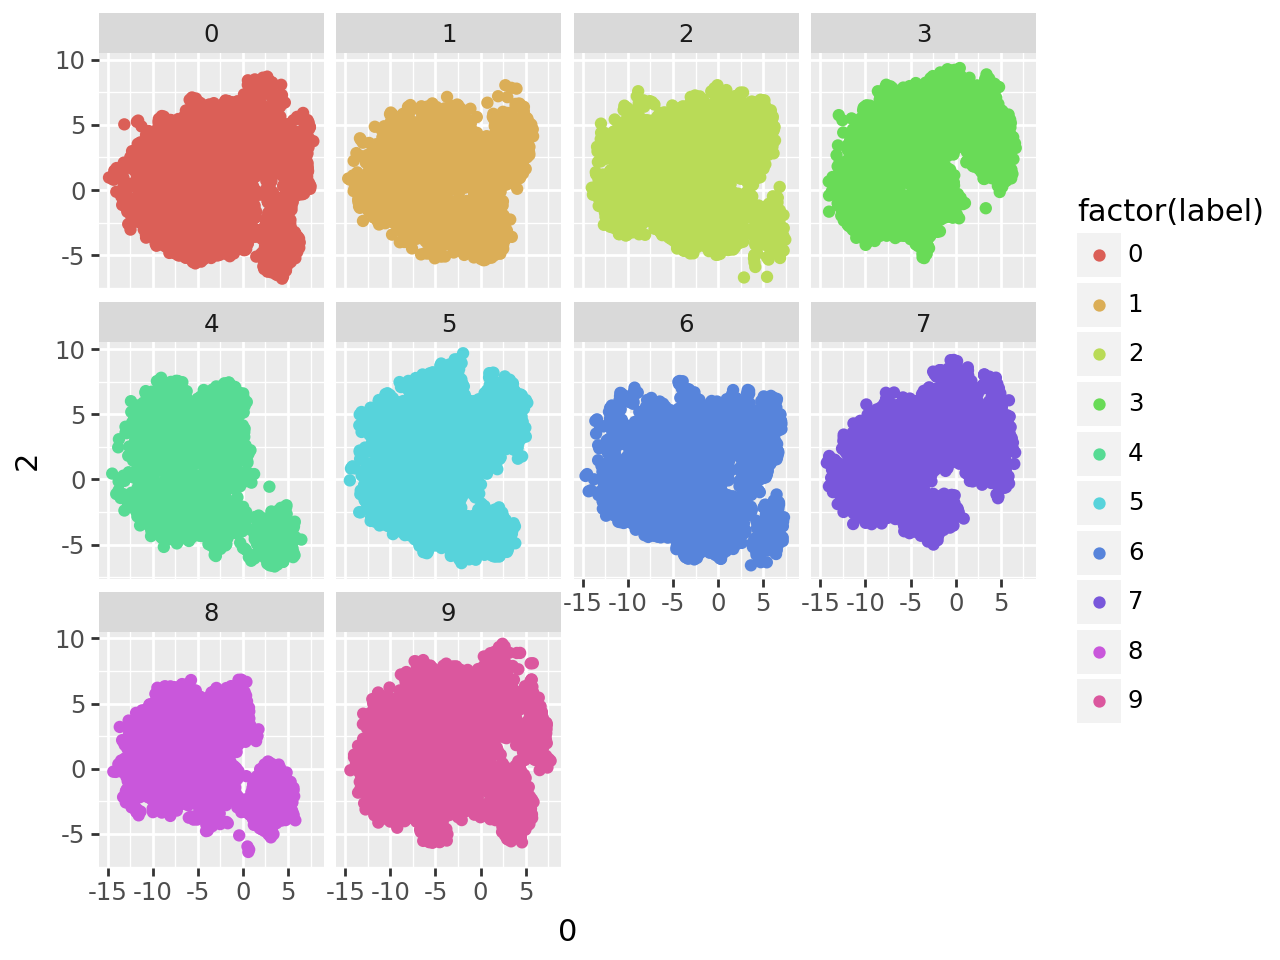

In [39]:
from plotnine import scale_x_log10

ggplot(mlp_posts_df, aes(x='0', y='2', color='factor(label)')) + geom_point() + facet_wrap('~label')

In [40]:
mlp_posts_df.filter(pl.col('0') < -100)

label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,…,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32


# Trial inputs

In [41]:
all_1 = torch.ones((25), dtype=torch.int32)
all_0 = torch.zeros((25), dtype=torch.int32)
all_1_label = (torch.cumsum(all_1, dim=0)) % 5
all_0_label = torch.tensor([5,0]*12+[0], dtype=torch.int32)
print(all_1_label)
print(all_0_label)

tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
        0])
tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        0], dtype=torch.int32)


In [42]:
# All zeros except a single one at one position
test = deepcopy(all_0)
test[8] = 1
print(test)

# All ones except a single zero at one position
test_2 = deepcopy(all_1)
test_2[8] = 0


l_all_1, cache_all_1 = model_3.run_with_cache(all_1)
print(torch.argmax(l_all_1, dim=-1))
l_all_0, cache_all_0 = model_3.run_with_cache(all_0)
print(torch.argmax(l_all_0, dim=-1))

_, test_cache = model_3.run_with_cache(test)
_, test_2_cache = model_3.run_with_cache(test_2)

_, test_cache_0 = model_0.run_with_cache(test)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], dtype=torch.int32)
tensor([[1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 5, 5, 8, 8, 4, 0, 7, 4, 7, 7, 7, 7, 7,
         7]], device='mps:0')
tensor([[5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5]], device='mps:0')


## First layer attention

This is a 5-state, 2-layer, 2-head transformer trained to 80% accuracy.

In [43]:
IDX = 8

In [44]:
att_0_0 = cache_0["pattern", 0, "attn"]
display_layer_heads(att_0_0, batch_idx=IDX)
display_layer_heads(att_0_0, batch_idx=IDX+1)

# residual stream at tokens where attending to
# patch in information from previous token positions at positions its attending to
# train probes to predict state the activation is in
# logistic regression on residual stream activations for probing
# interp 3 state
# does acc increase from 5 to 4?

att_test_0 = test_cache_0["pattern", 0, "attn"]
for head in range(2):
    imshow_attention(att_test_0[0, head])

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


In [45]:
att_1_0 = cache_1["pattern", 0, "attn"]
# for head in range(config.tflens_config.n_heads):
#   imshow(att_1[0,head,...])
display_layer_heads(att_1_0, batch_idx=IDX)
display_layer_heads(att_1_0, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


In [46]:
att_2_0 = cache_2["pattern", 0, "attn"]
display_layer_heads(att_2_0, batch_idx=IDX)
display_layer_heads(att_2_0, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


In [47]:
att_3_0 = cache_3["pattern", 0, "attn"]
display_layer_heads(att_3_0, batch_idx=IDX)
display_layer_heads(att_3_0, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


## Second layer attention

In [48]:
att_0_1 = cache_0["pattern", 1, "attn"]
display_layer_heads(att_0_1, batch_idx=IDX)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


In [49]:
att_1_1 = cache_1["pattern", 1, "attn"]
display_layer_heads(att_1_1, batch_idx=IDX)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


In [50]:
att_2_1 = cache_2["pattern", 1, "attn"]
display_layer_heads(att_2_1, batch_idx=IDX)
display_layer_heads(att_2_1, batch_idx=IDX+1)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0])
tensor(2, dtype=torch.int32)


In [51]:
att_3_1 = cache_3["pattern", 1, "attn"]
display_layer_heads(att_3_1, batch_idx=IDX)

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1])
tensor(9, dtype=torch.int32)


In [52]:
att_3_0_all_1 = cache_all_1["pattern", 0, "attn"]
for head in range(2):
    imshow_attention(att_3_0_all_1[0,head,...])

att_3_1_all_1 = cache_all_1["pattern", 1, "attn"]
for head in range(2):
    imshow_attention(att_3_1_all_1[0,head,...])

In [53]:
att_3_0_all_0 = cache_all_0["pattern", 1, "attn"]
for head in range(2):
    imshow_attention(att_3_0_all_0[0,head,...])

att_3_1_all_0 = cache_all_0["pattern", 1, "attn"]
for head in range(2):
    imshow_attention(att_3_1_all_0[0,head,...])

In [54]:
att_3_0_test = test_cache["pattern", 0, "attn"]
for head in range(2):
    imshow_attention(att_3_0_test[0,head,...])

att_3_1_test = test_cache["pattern", 1, "attn"]
for head in range(2):
    imshow_attention(att_3_1_test[0,head,...])

In [55]:
att_3_0_test_2 = test_2_cache["pattern", 0, "attn"]
for head in range(2):
    imshow_attention(att_3_0_test_2[0,head,...])

att_3_1_test_2 = test_2_cache["pattern", 1, "attn"]
for head in range(2):
    imshow_attention(att_3_1_test_2[0,head,...])

# More trial inputs

In [56]:
all_1 = torch.ones((25), dtype=torch.int32)
all_0 = torch.zeros((25), dtype=torch.int32)
all_1_label = (torch.cumsum(all_1, dim=0)) % 5
all_0_label = torch.tensor([5,0]*12+[0], dtype=torch.int32)
print(all_1_label)
print(all_0_label)

tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
        0])
tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0,
        0], dtype=torch.int32)


In [57]:
test = deepcopy(all_0)
test[5] = 1
print(test)

test_2 = deepcopy(all_1)
test_2[18] = 0

_, test_cache = model_3.run_with_cache(test)
_, test_2_cache = model_3.run_with_cache(test_2)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], dtype=torch.int32)


In [58]:
att_3_0_test = test_cache["pattern", 0, "attn"]
for head in range(2):
    imshow_attention(att_3_0_test[0,head,...])

att_3_1_test = test_cache["pattern", 1, "attn"]
for head in range(2):
    imshow_attention(att_3_1_test[0,head,...])

In [59]:
att_3_0_test_2 = test_2_cache["pattern", 0, "attn"]
for head in range(2):
    imshow_attention(att_3_0_test_2[0,head,...])

att_3_1_test_2 = test_2_cache["pattern", 1, "attn"]
for head in range(2):
    imshow_attention(att_3_1_test_2[0,head,...])

# OV circuit analysis post form 2

In [60]:
print(cache_1["scale"].shape)
# Layernorm scale, [batch, pos, 1]

torch.Size([64, 25, 1])


In [61]:
# [nlayers nheads dmodel dhead] x [nlayers nheads dmodel dhead].T
W_OV = model_0.W_V @ model_0.W_O # [nlayers nheads dmodel dmodel]
W_E = model_0.W_E # [vocab_in dhead]
W_U = model_0.W_U # [vocab_out dhead]
print(W_E.shape)

torch.Size([10, 128])


In [62]:
scale_final = cache_1["scale"][:, :, 0].mean()
scale_0 = cache_1["scale", 0, "ln1"].mean()
scale_1 = cache_1["scale", 1, "ln1"].mean()

In [63]:
print(W_OV[1].shape)
print(W_OV[0].shape)
print(W_OV.shape)

torch.Size([2, 128, 128])
torch.Size([2, 128, 128])
torch.Size([2, 2, 128, 128])


In [64]:
# ! Get direct path
W_E_OV_direct = (W_E / scale_final) @ W_U
print(f"Direct {W_E_OV_direct.shape}") # [vocab_out vocab_out]

# ! Get full OV matrix for path through just layer 0
W_E_OV_0 = (W_E / scale_0) @ W_OV[0]
W_OV_0_full = (W_E_OV_0 / scale_final) @ W_U # [n_head vocab_in vocab_out]
print(f"Layer 0 {W_OV_0_full.shape}")

# ! Get full OV matrix for path through just layer 1
W_E_OV_1 = (W_E / scale_1) @ W_OV[1]
W_OV_1_full = (W_E_OV_1 / scale_final) @ W_U # [n_head vocab_in vocab_out]
print(f"Layer 1 {W_OV_1_full.shape}")

# ! Get full OV matrix for path through heads in layer 0 and 1
W_E_OV_01 = einops.einsum(
    (W_E_OV_0 / scale_1), W_OV[1],
    "head0 vocab_in d_model_in, head1 d_model_in d_model_out -> head0 head1 vocab_in d_model_out",
)
W_OV_01_full = (W_E_OV_01 / scale_final) @ W_U # [head0 head1 vocab_in vocab_out]
print(f"Layers 0, 1 {W_OV_01_full.shape}")

Direct torch.Size([10, 10])
Layer 0 torch.Size([2, 10, 10])
Layer 1 torch.Size([2, 10, 10])
Layers 0, 1 torch.Size([2, 2, 10, 10])


In [65]:
print(W_E_OV_direct[None, None].shape)
print(W_OV_0_full[:, None].shape)
print(W_OV_1_full[None].shape)
print(W_OV_01_full.shape)

cat_1 = torch.cat([W_E_OV_direct[None, None], W_OV_0_full[:, None]]) # [head0 1 vocab_in vocab_out]
cat_2 = torch.cat([W_OV_1_full[None], W_OV_01_full])  # [head0 head1 vocab_in vocab_out]
print(cat_1.shape, cat_2.shape)

W_OV_full_all = torch.cat([
    cat_1,
    cat_2,
], dim=1) # [head0 head1 vocab_in vocab_out]
print(W_OV_full_all.shape)
print(W_OV_full_all.transpose(0, 1).flatten(0, 1).shape)

torch.Size([1, 1, 10, 10])
torch.Size([2, 1, 10, 10])
torch.Size([1, 2, 10, 10])
torch.Size([2, 2, 10, 10])
torch.Size([3, 1, 10, 10]) torch.Size([3, 2, 10, 10])
torch.Size([3, 3, 10, 10])
torch.Size([9, 10, 10])


In [66]:
tokens = [str(i) for i in range(10)]
components_0 = ["W<sub>E</sub>"] + [f"0.{i}" for i in range(2)]
components_1 = ["W<sub>U</sub>"] + [f"1.{i}" for i in range(2)]

# Using dict.fromkeys() prevents repeats
facet_labels = [" ➔ ".join(list(dict.fromkeys(["W<sub>E</sub>", c0, c1, "W<sub>U</sub>"]))) for c1 in components_1 for c0 in components_0]
imshow(
    W_OV_full_all.transpose(0, 1).flatten(0, 1), # .softmax(dim=-1),
    facet_col = 0,
    facet_col_wrap = 3,
    facet_labels = facet_labels,
    title = f"Full virtual OV circuits",
    x = tokens,
    y = tokens,
    labels = {"x": "Source", "y": "Dest"},
    height = 1200,
    width = 1200,
    # text = text,
)

Reordered labels: ['W<sub>E</sub> ➔ 1.1 ➔ W<sub>U</sub>', 'W<sub>E</sub> ➔ 0.0 ➔ 1.1 ➔ W<sub>U</sub>', 'W<sub>E</sub> ➔ 0.1 ➔ 1.1 ➔ W<sub>U</sub>', 'W<sub>E</sub> ➔ 1.0 ➔ W<sub>U</sub>', 'W<sub>E</sub> ➔ 0.0 ➔ 1.0 ➔ W<sub>U</sub>', 'W<sub>E</sub> ➔ 0.1 ➔ 1.0 ➔ W<sub>U</sub>', 'W<sub>E</sub> ➔ W<sub>U</sub>', 'W<sub>E</sub> ➔ 0.0 ➔ W<sub>U</sub>', 'W<sub>E</sub> ➔ 0.1 ➔ W<sub>U</sub>']


In [69]:
imshow_attention(model_1.W_pos @ model_1.W_pos.T)